In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']


BS_animal_M2 = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
animals = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'Z:\\Behavioor'

stdfont = 14
stdyfrac = 0.06

M2_FRmod_baseline_median = 2.3
AC_FRmod_baseline_median = 3.5

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


In [2]:
import pandas as pd
from pathlib import Path
import numpy as np
import os
import matplotlib.pyplot as plt
import dlc2kinematics

C:\Users\insan\anaconda3\envs\Ephyanalysis\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
dataname1 = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video1\\Test1_309DLC_resnet50_Training_projectApr9shuffle1_500000.h5'
dataskeleton1 = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video_skeleton\\Test1_309DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.h5'

dataframe1 = pd.read_hdf(os.path.join(dataname1))
dataskeleton1 = pd.read_hdf(os.path.join(dataskeleton1))
likelihood_thres = 0.9

In [4]:
dataname2 = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video2\\Test2_310DLC_resnet50_Training_projectApr9shuffle1_500000.h5'
dataskeleton2 = 'C:\\Users\\insan\\Desktop\\Motion project training\\Analysis_video2\\Test2_310DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.h5'

dataframe2 = pd.read_hdf(os.path.join(dataname2))
dataskeleton2 = pd.read_hdf(os.path.join(dataskeleton2))
likelihood_thres = 0.9

In [5]:
dataname3 = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video3\\Test3_310DLC_resnet50_Training_projectApr9shuffle1_500000.h5'
dataskeleton3 = 'C:\\Users\\insan\\Desktop\\Motion project training\\Analysis_video3\\Test3_310DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.h5'

dataframe3 = pd.read_hdf(os.path.join(dataname3))
dataskeleton3 = pd.read_hdf(os.path.join(dataskeleton3))
likelihood_thres = 0.9

In [6]:
dataname4 = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video4\\Test4_309DLC_resnet50_Training_projectApr9shuffle1_500000.h5'
dataskeleton4 = 'C:\\Users\\insan\\Desktop\\Motion project training\\Analysis_video4\\Test4_309DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.h5'

dataframe4 = pd.read_hdf(os.path.join(dataname4))
dataskeleton4 = pd.read_hdf(os.path.join(dataskeleton4))
likelihood_thres = 0.9

In [7]:
dataname5 = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video5\\Test5_308DLC_resnet50_Training_projectApr9shuffle1_500000.h5'
dataskeleton5 = 'C:\\Users\\insan\\Desktop\\Motion project training\\Analysis_video5\\Test5_308DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.h5'

dataframe5 = pd.read_hdf(os.path.join(dataname5))
dataskeleton5 = pd.read_hdf(os.path.join(dataskeleton5))
likelihood_thres = 0.9

In [8]:
def cal_pupildiameter(dlc_pupileye,dlc_pupileyeskeleton):
    
    #
    pupilup = dlc_pupileye.iloc[:,0:3]
    pupildown = dlc_pupileye.iloc[:,3:6]
    pupilleft = dlc_pupileye.iloc[:,6:9]
    pupilright = dlc_pupileye.iloc[:,9:12]

    pupilup_arr = np.array(pupilup)
    pupildown_arr = np.array(pupildown)
    pupilleft_arr = np.array(pupilleft)
    pupilright_arr = np.array(pupilright)
    
    pupil_down_likelihood = pupildown_arr[:,2]
    
    #
    pupil_updown = dlc_pupileyeskeleton.iloc[:,0:3]
    pupil_updown_arr = np.array(pupil_updown)

    pupil_leftright = dlc_pupileyeskeleton.iloc[:,3:6]
    pupil_leftright_arr = np.array(pupil_leftright)
    
    pupilvdiameter = pupil_updown_arr[:,0]
    pupilhdiameter = pupil_leftright_arr[:,0]

    pupil_updown_likelihood = pupil_updown_arr[:,2]
    pupildiameter = np.mean((pupilvdiameter,pupilhdiameter),axis=0)
    
    #
    for frame,likelihood in enumerate(pupil_down_likelihood):
        if likelihood < likelihood_thres:
            pupildiameter[frame] = pupilhdiameter[frame]
        
    return pupildiameter

meta NOT subset; don't know how to subset; dropped


2075


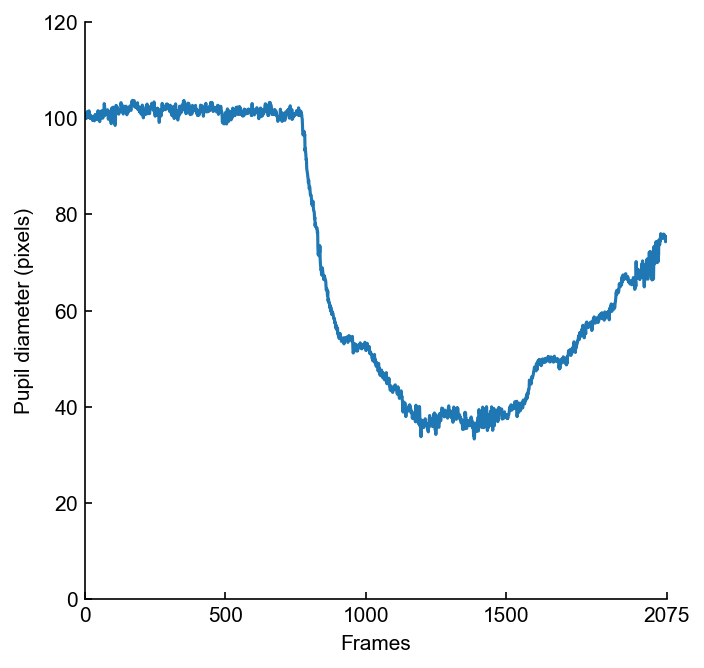

In [9]:
pupildiameter1 = cal_pupildiameter(dataframe1,dataskeleton1)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter1)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,2075])
ax.set_xticks([0,500,1000,1500,2075])
ax.set_xticklabels(['0','500','1000','1500','2075'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis1.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

print(len(pupildiameter1))

meta NOT subset; don't know how to subset; dropped


23702


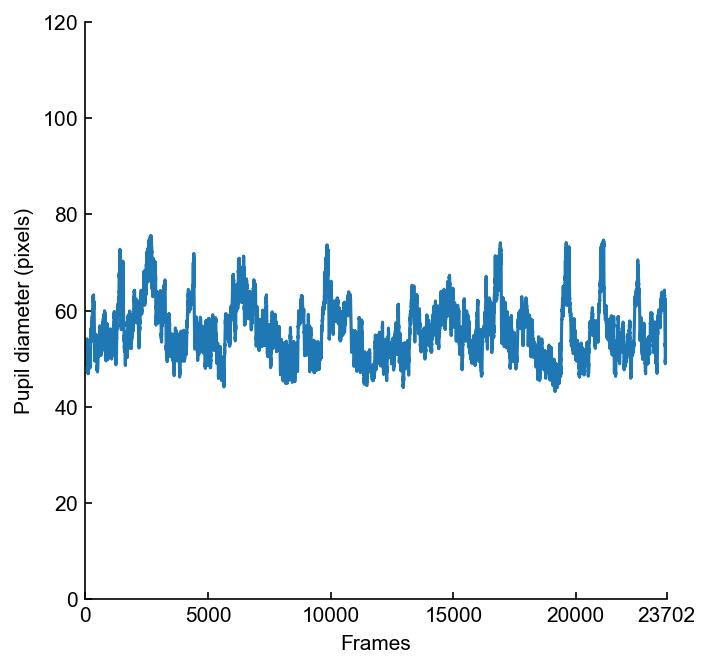

In [10]:
pupildiameter2 = cal_pupildiameter(dataframe2,dataskeleton2)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter2)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,23702])
ax.set_xticks([0,5000,10000,15000,20000,23702])
ax.set_xticklabels(['0','5000','10000','15000','20000','23702'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis2.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


print(len(pupildiameter2))

meta NOT subset; don't know how to subset; dropped


728


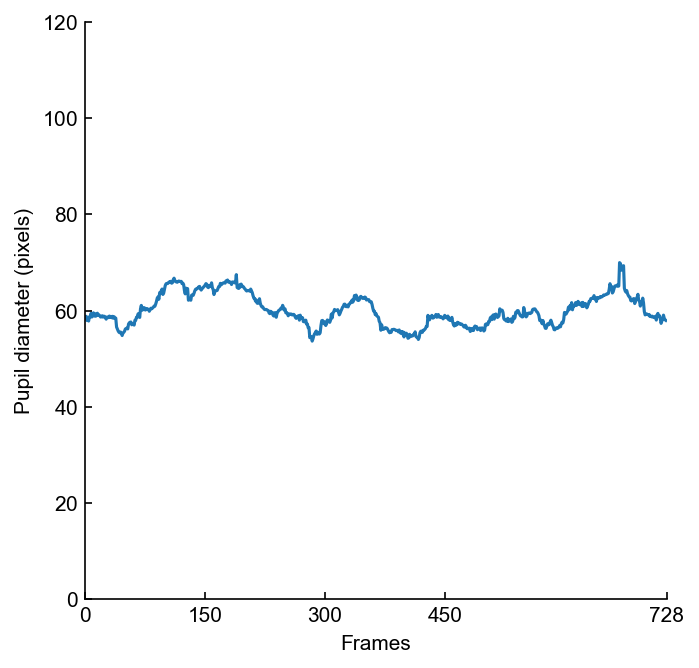

In [11]:
pupildiameter3 = cal_pupildiameter(dataframe3,dataskeleton3)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter3)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,728])
ax.set_xticks([0,150,300,450,728])
ax.set_xticklabels(['0','150','300','450','728'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis3.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

print(len(pupildiameter3))

meta NOT subset; don't know how to subset; dropped


613


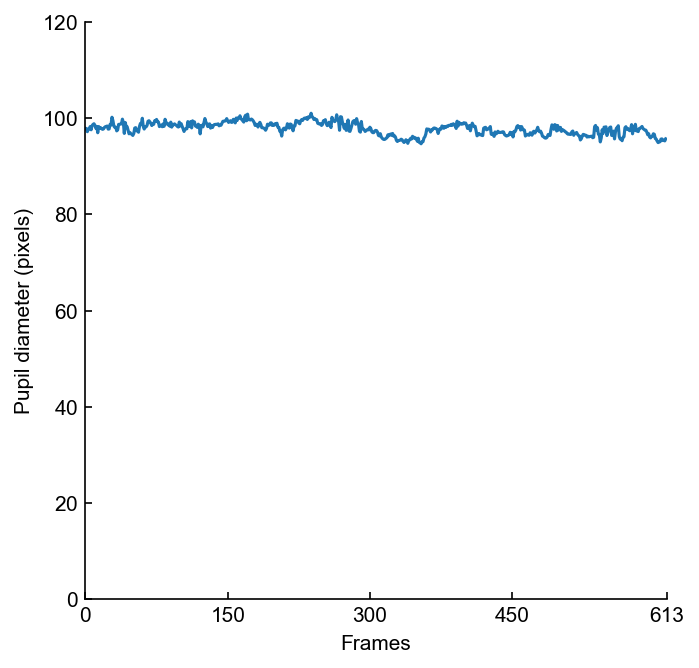

In [12]:
pupildiameter4 = cal_pupildiameter(dataframe4,dataskeleton4)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter4)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,613])
ax.set_xticks([0,150,300,450,613])
ax.set_xticklabels(['0','150','300','450','613'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis4.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


print(len(pupildiameter4))

In [153]:
np.arange(10)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [158]:
pupildiameter5 = cal_pupildiameter(dataframe5,dataskeleton5)

fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter5)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,695])
ax.set_xticks([0,150,300,450,695])
ax.set_xticklabels(['0','150','300','450','695'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis5.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

plt.close()
print(len(pupildiameter5))

meta NOT subset; don't know how to subset; dropped


695


In [43]:
pupildiameter5

array([68.67258043, 69.23184799, 68.89092794, 68.55748466, 68.64524348,
       68.71393788, 68.53012525, 68.86988674, 69.00328711, 69.14405569,
       69.57311521, 69.32055016, 68.32535701, 68.25385181, 67.84640286,
       68.44729192, 68.47937986, 70.88626887, 70.83198341, 69.09723247,
       71.80629316, 71.74800392, 68.90805229, 68.83254547, 69.81806377,
       69.16969509, 69.2189604 , 69.58944788, 69.63900705, 69.14260381,
       70.70149935, 71.80153089, 72.02319075, 71.68001014, 71.44991548,
       71.40430973, 70.96894748, 70.87515378, 72.15560138, 71.23753774,
       71.51843632, 69.23168631, 69.74676986, 70.11579259, 70.08960239,
       70.01594527, 72.08023099, 72.48158398, 72.22749636, 72.49909786,
       71.82492167, 71.87339392, 72.09756349, 72.29606356, 72.33458133,
       72.35032943, 71.77035062, 70.581559  , 70.85157892, 70.04259911,
       73.80267841, 73.17419313, 73.78554921, 72.68642039, 72.9846705 ,
       73.19184321, 73.35769345, 73.35279787, 73.59918034, 73.56

# animation test

In [77]:
import matplotlib.animation
import matplotlib.pyplot as plt
import numpy as np
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  
plt.ioff()
fig, ax = plt.subplots()

x= np.linspace(0,10,200)

def animate(t):
    print(t)
    plt.plot(x-t,x)

    plt.xlim(0,10)

matplotlib.animation.FuncAnimation(fig, animate, frames=20)


0
200
0
200
1
200
2
200
3
200
4
200
5
200
6
200
7
200
8
200
9
200
10
200
11
200
12
200
13
200
14
200
15
200
16
200
17
200
18
200
19
200


In [146]:
x = pupildiameter5[:20]
plotx = []
tt = []
def animate(t):
    plotx.append(x[t])
    tt.append(t)
    #print(plotx)
    plt.plot(plotx,tt,color='r')
    
matplotlib.animation.FuncAnimation(fig,animate, frames=len(pupildiameter5[:20]))


In [87]:
x = np.linspace(0,10,10)

In [88]:
x

array([ 0.        ,  1.11111111,  2.22222222,  3.33333333,  4.44444444,
        5.55555556,  6.66666667,  7.77777778,  8.88888889, 10.        ])

In [89]:
plotx = []

In [92]:
plotx.append(x[1])

In [93]:
plotx

[0.0, 1.1111111111111112]

In [57]:
x = []

In [58]:
for diameter in pupildiameter5:
    x.append(diameter)

In [14]:
pupildiameter5

array([68.67258043, 69.23184799, 68.89092794, 68.55748466, 68.64524348,
       68.71393788, 68.53012525, 68.86988674, 69.00328711, 69.14405569,
       69.57311521, 69.32055016, 68.32535701, 68.25385181, 67.84640286,
       68.44729192, 68.47937986, 70.88626887, 70.83198341, 69.09723247,
       71.80629316, 71.74800392, 68.90805229, 68.83254547, 69.81806377,
       69.16969509, 69.2189604 , 69.58944788, 69.63900705, 69.14260381,
       70.70149935, 71.80153089, 72.02319075, 71.68001014, 71.44991548,
       71.40430973, 70.96894748, 70.87515378, 72.15560138, 71.23753774,
       71.51843632, 69.23168631, 69.74676986, 70.11579259, 70.08960239,
       70.01594527, 72.08023099, 72.48158398, 72.22749636, 72.49909786,
       71.82492167, 71.87339392, 72.09756349, 72.29606356, 72.33458133,
       72.35032943, 71.77035062, 70.581559  , 70.85157892, 70.04259911,
       73.80267841, 73.17419313, 73.78554921, 72.68642039, 72.9846705 ,
       73.19184321, 73.35769345, 73.35279787, 73.59918034, 73.56

# Test

In [ ]:
dataname = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video1\\Test1_309DLC_resnet50_Training_projectApr9shuffle1_500000.h5'
dataskeleton = 'C:\\Users\insan\\Desktop\\Motion project training\\Analysis_video_skeleton\\Test1_309DLC_resnet50_Training_projectApr9shuffle1_500000_skeleton.h5'

dataframe = pd.read_hdf(os.path.join(dataname))
dataskeleton = pd.read_hdf(os.path.join(dataskeleton))
likelihood_thres = 0.9

In [283]:
dataframe

scorer    DLC_resnet50_Training_projectApr9shuffle1_500000              \
bodyparts                                          Pupilup               
coords                                                   x           y   
0                                               188.821274  107.021141   
1                                               189.158279  106.474670   
2                                               187.382568  106.426804   
3                                               187.476578  106.142487   
4                                               187.043900  104.590973   
..                                                     ...         ...   
608                                             189.070328  105.089691   
609                                             189.271820  104.984421   
610                                             189.059799  105.053596   
611                                             190.970352  105.515297   
612                                             189.862274  105.336937   

scorer                                                               \
bodyparts              Pupildown                          Pupilleft   
coords    likelihood           x           y likelihood           x   
0           0.999992  183.705688  196.717667   0.002983  143.965744   
1           0.999990  183.152802  196.133362   0.001999  144.536835   
2           0.999986  182.558136  196.198608   0.003161  144.626770   
3           0.999985    0.266461    4.992319   0.000219  144.235001   
4           0.999920  183.327194  197.712372   0.000590  143.094986   
..               ...         ...         ...        ...         ...   
608         0.999989  183.019394  195.614746   0.000793  144.661835   
609         0.999989  182.995224  195.516022   0.000766  144.845840   
610         0.999989  182.652206  194.986664   0.000867  144.784714   
611         0.999984  211.280716  182.239380   0.000849  145.430359   
612         0.999985  211.403656  182.119171   0.001146  145.297836   

scorer                                        ...                         \
bodyparts                         Pupilright  ...   Eyelidup  Eyeliddown   
coords              y likelihood           x  ... likelihood           x   
0          162.491379   0.999999  241.311279  ...   0.999962  201.455215   
1          161.486206   0.999999  241.955994  ...   0.999927  201.928024   
2          163.127029   0.999999  241.251526  ...   0.999939  200.736267   
3          165.550568   0.999997  241.292740  ...   0.999949  199.727707   
4          163.009445   0.999999  240.207611  ...   0.999944  197.257599   
..                ...        ...         ...  ...        ...         ...   
608        162.083542   0.999999  239.421051  ...   0.999936  200.542236   
609        161.997574   1.000000  239.267197  ...   0.999941  200.332672   
610        161.358017   1.000000  239.339691  ...   0.999936  200.282410   
611        160.792908   1.000000  240.059799  ...   0.999833  200.308273   
612        161.502304   0.999999  240.238052  ...   0.999881  199.815430   

scorer                                                               \
bodyparts                         Eyelidleft                          
coords              y likelihood           x           y likelihood   
0          200.728195   0.999944  129.215912  179.798615   0.999995   
1          200.371567   0.999943  129.167862  179.573029   0.999997   
2          203.521744   0.999854  129.359741  180.160019   0.999995   
3          202.610214   0.999845  128.903442  181.279358   0.999992   
4          201.469284   0.999889  127.277061  178.776947   0.999987   
..                ...        ...         ...         ...        ...   
608        198.036133   0.999935  129.401901  179.443054   0.999997   
609        197.887146   0.999948  129.551270  179.224380   0.999998   
610        197.581146   0.999937  129.690506  179.487488   0.999999   
611        196.645050   0.999953  129.824219  177.7

In [292]:
dataskeleton

Pupilup_Pupildown                        Pupilleft_Pupilright              \
               length orientation likelihood               length orientation   
0           89.842284   93.264165   0.002983            97.897660  353.912001   
1           89.859594   93.832036   0.001999            97.829030  354.753387   
2           89.901346   93.076177   0.003161            97.183344  353.853954   
3          212.788590  208.382481   0.000219            97.704775  353.402435   
4           93.195541   92.285603   0.000590            97.784226  353.280953   
..                ...         ...        ...                  ...         ...   
608         90.727060   93.824113   0.000793            95.685788  352.019971   
609         90.748920   93.965995   0.000766            95.337771  352.049404   
610         90.161044   94.075350   0.000867            95.401370  352.362209   
611         79.366843   75.172789   0.000849            95.269547  353.354463   
612         79.746740   74.328449   0.001146            95.692013  352.813212   

               Eyelidup_Eyelidleft                         \
    likelihood              length orientation likelihood   
0     0.999996          103.247234  122.775965   0.999995   
1     0.999997          103.145603  122.803447   0.999997   
2     0.999996          103.102981  122.162169   0.999995   
3     0.999998          104.518049  121.639601   0.999992   
4     0.999992          104.027726  122.285900   0.999987   
..         ...                 ...         ...        ...   
608   0.999999          102.783078  121.562460   0.999997   
609   0.999999          102.812246  121.489819   0.999998   
610   0.999999          103.061734  121.388857   0.999999   
611   0.999999          102.385096  122.626902   0.999997   
612   0.999999          102.453276  122.351455   0.999997   

    Eyelidup_Eyelidright                        Eyeliddown_Eyelidleft  \
                  length orientation likelihood                length   
0              95.423513   37.393711   0.999987             75.210134   
1              96.025679   37.353845   0.999978             75.674437   
2              96.001104   37.981447   0.999966             75.102454   
3              96.629627   38.074590   0.999973             73.966762   
4              97.514422   37.669984   0.999988             73.567777   
..                   ...         ...        ...                   ...   
608            96.188545   37.056606   0.999996             73.529925   
609            96.466077   37.246156   0.999996             73.200449   
610            96.404874   37.184802   0.999996             72.873845   
611            95.515763   38.317691   0.999996             72.981994   
612            96.177385   38.306249   0.999994             72.490230   

                           Eyeliddown_Eyelidright                         
    orientation likelihood                 length orientation likelihood  
0    196.157659   0.999995              77.558051  320.061458   0.999987  
1    195.952618   0.999997              77.190573  320.370520   0.999978  
2    198.123408   0.999995              78.489362  318.932564   0.999966  
3    196.761254   0.999992              78.621866  319.822404   0.999973  
4    197.966137   0.999987              80.906627  320.883070   0.999988  
..          ...        ...                    ...         ...        ...  
608  194.647060   0.999997              76.517446  320.948051   0.999996  
609  194.770874   0.999998              76.581929  321.236042   0.999996  
610  194.376193   0.999999              76.632358  321.402650   0.999996  
611  195.033748   0.999997              75.295567  322.403579   0.999996  
612  194.972711   0.999997              75.611035  322.849624   0.999994  

[613 rows x 18 columns]

In [285]:
df_pupilup = dataframe.iloc[:,0:3]
df_pupildown = dataframe.iloc[:,3:6]
df_pupilleft = dataframe.iloc[:,6:9]
df_pupilright = dataframe.iloc[:,9:12]

df_pupilup_arr = np.array(df_pupilup)
df_pupildown_arr = np.array(df_pupildown)
df_pupilleft_arr = np.array(df_pupilleft)
df_pupilright_arr = np.array(df_pupilright)

In [286]:
pupil_updown = dataskeleton.iloc[:,0:3]
pupil_updown_arr = np.array(pupil_updown)

pupil_leftright = dataskeleton.iloc[:,3:6]
pupil_leftright_arr = np.array(pupil_leftright)


In [287]:
pupilvdiameter = pupil_updown_arr[:,0]
pupilhdiameter = pupil_leftright_arr[:,0]

pupil_updownlikelihood = pupil_updown_arr[:,2]
pupildiameter = np.mean((pupilvdiameter,pupilhdiameter),axis=0)

In [291]:
for frame,likelihood in enumerate(pupil_updownlikelihood):
    if likelihood < likelihood_thres:
        pupildiameter[frame] = pupilhdiameter[frame]

meta NOT subset; don't know how to subset; dropped


2075


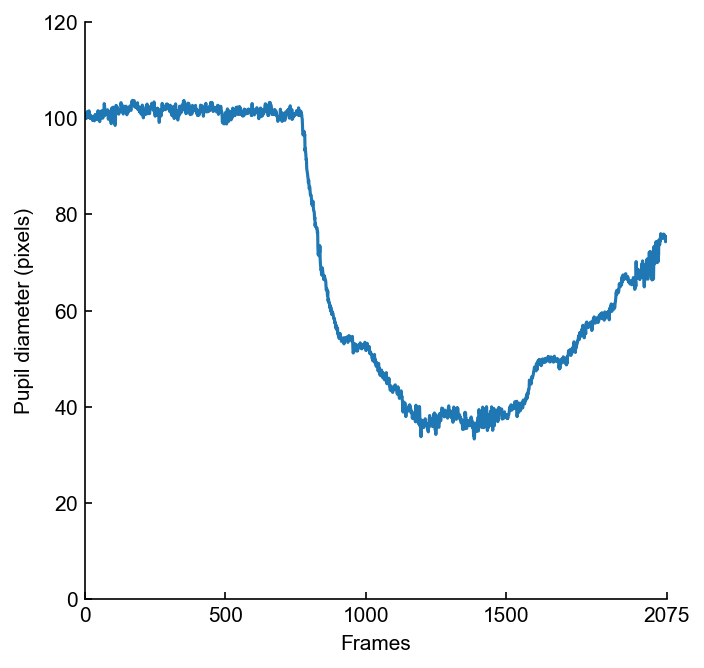

In [272]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,2075])
ax.set_xticks([0,500,1000,1500,2075])
ax.set_xticklabels(['0','500','1000','1500','2075'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis1.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')

print(len(pupildiameter))

meta NOT subset; don't know how to subset; dropped


23702


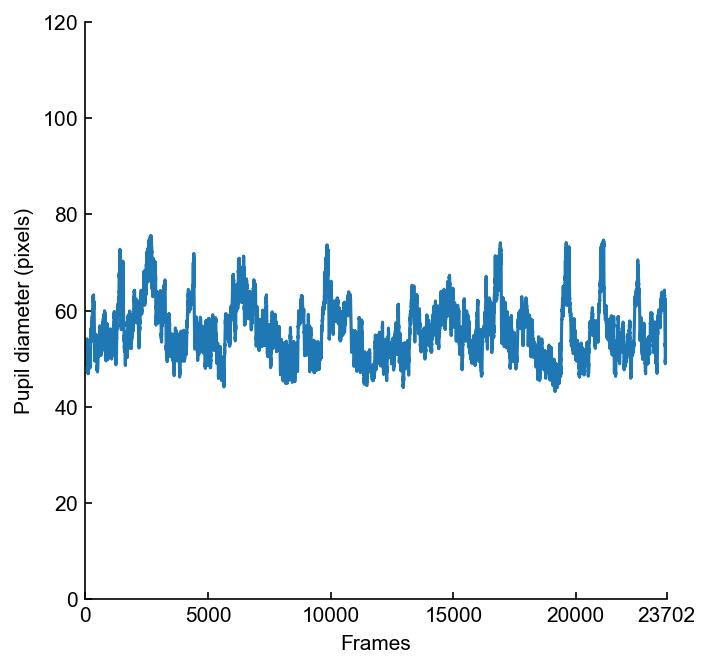

In [281]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,23702])
ax.set_xticks([0,5000,10000,15000,20000,23702])
ax.set_xticklabels(['0','5000','10000','15000','20000','23702'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis2.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


print(len(pupildiameter))

meta NOT subset; don't know how to subset; dropped


613


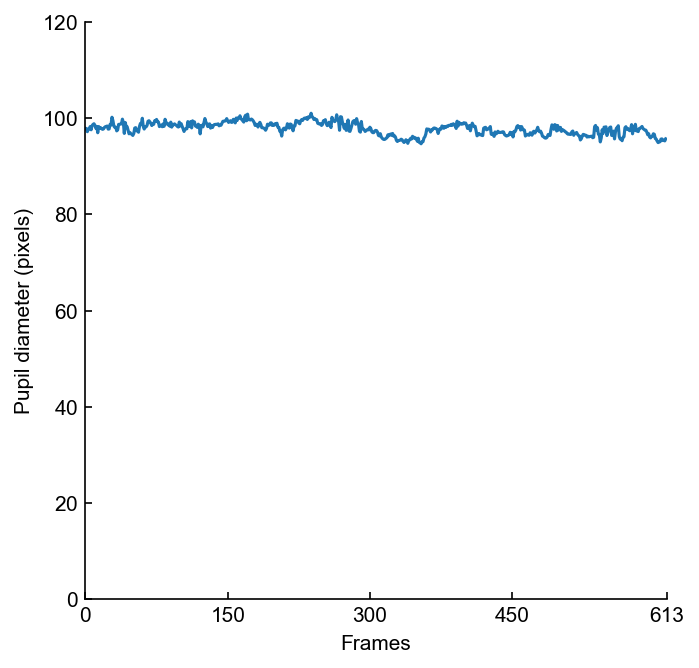

In [290]:
fig,ax = plt.subplots(figsize=(5,5))
ax.plot(pupildiameter)
ax.set_ylabel('Pupil diameter (pixels)')
ax.set_xlabel('Frames')

ax.set_ylim([0,120])

ax.set_xlim([0,613])
ax.set_xticks([0,150,300,450,613])
ax.set_xticklabels(['0','150','300','450','613'])
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\Pupil_analysis\\analysis4.pdf'),transparent=False,facecolor="white",dpi=400, bbox_inches='tight')


print(len(pupildiameter))

In [162]:
pupilhdiameter

array([100.01651719, 100.91469115, 100.39090122, ...,  74.58975758,
        75.37962584,  75.31219013])

In [176]:
pupildiameter [:20]

array([100.01651719, 100.91469115, 100.39090122, 100.6701095 ,
       100.24572614, 100.01338944, 100.83063433, 101.30425015,
       101.26924577, 101.40801181, 101.27990912, 100.90249582,
       101.27665745, 101.50911664, 100.59405052, 100.90907133,
       100.46967763,  99.91830801, 100.5602957 , 100.03323348])

In [177]:
np.mean((pupilvdiameter[1525],pupilhdiameter[1525]))

39.508650762282784

In [178]:
pupilhdiameter [1520:1620]

array([39.77052355, 39.58108705, 40.53366092, 40.64455632, 40.54017529,
       40.30914706, 41.2848455 , 40.60232485, 40.69663692, 40.985302  ,
       41.18244898, 41.02866776, 40.37661096, 41.93419057, 41.02068891,
       41.70261428, 41.42205618, 41.51887713, 41.09699411, 40.42198005,
       42.27008616, 38.43162124, 40.60025401, 40.30837911, 39.74991939,
       40.46002491, 39.81342828, 39.93964834, 41.25796311, 41.00970933,
       41.45354154, 41.88576866, 40.53939726, 40.81244236, 40.71430148,
       41.82632977, 41.93481384, 41.68623945, 40.9223026 , 41.4864665 ,
       41.81872138, 40.92974235, 42.13189254, 42.14925593, 42.04864351,
       42.25082397, 42.51465714, 42.34324644, 42.14981611, 42.35214688,
       43.01132367, 43.27548482, 43.05012178, 43.75110031, 44.08488359,
       43.90132352, 44.33933484, 43.98933215, 44.12752433, 44.77263438,
       44.5173249 , 44.8506418 , 45.39159498, 45.54591796, 45.74521284,
       46.76186589, 46.54621517, 46.28816224, 46.1434484 , 46.42

In [179]:
pupilvdiameter [1520:1620]

array([40.39445652, 38.97454571, 40.16081966, 39.83068997, 39.44452133,
       38.70815446, 38.85808594, 38.62405968, 39.41202483, 39.02660691,
       38.89903778, 38.85220931, 38.9169555 , 40.20615681, 39.3869324 ,
       39.09858959, 39.55469693, 40.14157557, 39.8017345 , 38.7802175 ,
       40.07662229, 37.4983614 , 38.24305719, 38.96361421, 38.13954414,
       38.51820866, 37.99440561, 37.78249984, 38.81621242, 38.34504675,
       39.09838953, 39.6790677 , 37.98689211, 37.63413254, 38.23129406,
       39.58044514, 38.98635675, 39.85161142, 38.74364905, 38.75690595,
       38.99298559, 38.64098851, 39.70760067, 40.67558907, 39.37008818,
       39.43222996, 39.08264668, 39.08157111, 39.11791512, 39.51761872,
       40.23851922, 39.62002711, 39.59253436, 39.78389533, 40.25777221,
       40.00628901, 41.05843354, 39.59572563, 39.974191  , 41.01425651,
       40.7918576 , 41.97308246, 41.75953217, 41.52873078, 42.15218863,
       44.39489586, 43.75220164, 44.31439205, 44.21823959, 44.33

In [170]:
pupildiameter [1520:1620]

array([40.08249004, 39.27781638, 40.34724029, 40.23762315, 39.99234831,
       39.50865076, 40.07146572, 39.61319226, 40.05433087, 40.00595445,
       40.04074338, 39.94043854, 39.64678323, 41.07017369, 40.20381066,
       40.40060193, 40.48837655, 40.83022635, 40.4493643 , 39.60109877,
       41.17335422, 37.96499132, 39.4216556 , 39.63599666, 38.94473177,
       39.48911678, 38.90391694, 38.86107409, 40.03708777, 39.67737804,
       40.27596553, 40.78241818, 39.26314468, 39.22328745, 39.47279777,
       40.70338746, 40.46058529, 40.76892543, 39.83297582, 40.12168622,
       40.40585349, 39.78536543, 40.9197466 , 41.4124225 , 40.70936585,
       40.84152696, 40.79865191, 40.71240877, 40.63386561, 40.9348828 ,
       41.62492144, 41.44775596, 41.32132807, 41.76749782, 42.1713279 ,
       41.95380626, 42.69888419, 41.79252889, 42.05085766, 42.89344544,
       42.65459125, 43.41186213, 43.57556357, 43.53732437, 43.94870073,
       45.57838087, 45.1492084 , 45.30127715, 45.180844  , 45.37

## Check distance (no need to run)

In [103]:
df_pupildown_arr[0]

array([1.85479355e+02, 1.88340942e+02, 3.57112585e-04])

In [113]:
a = df_pupildown_arr[1,0:2]

In [114]:
a

array([219.76791382,  89.92604828])

In [115]:
b=df_pupilup_arr[1,0:2]

In [116]:
b

array([214.63412476, 110.88870239])

In [117]:
d = np.linalg.norm(a-b)

In [118]:
d

21.58213746670573


## Plot

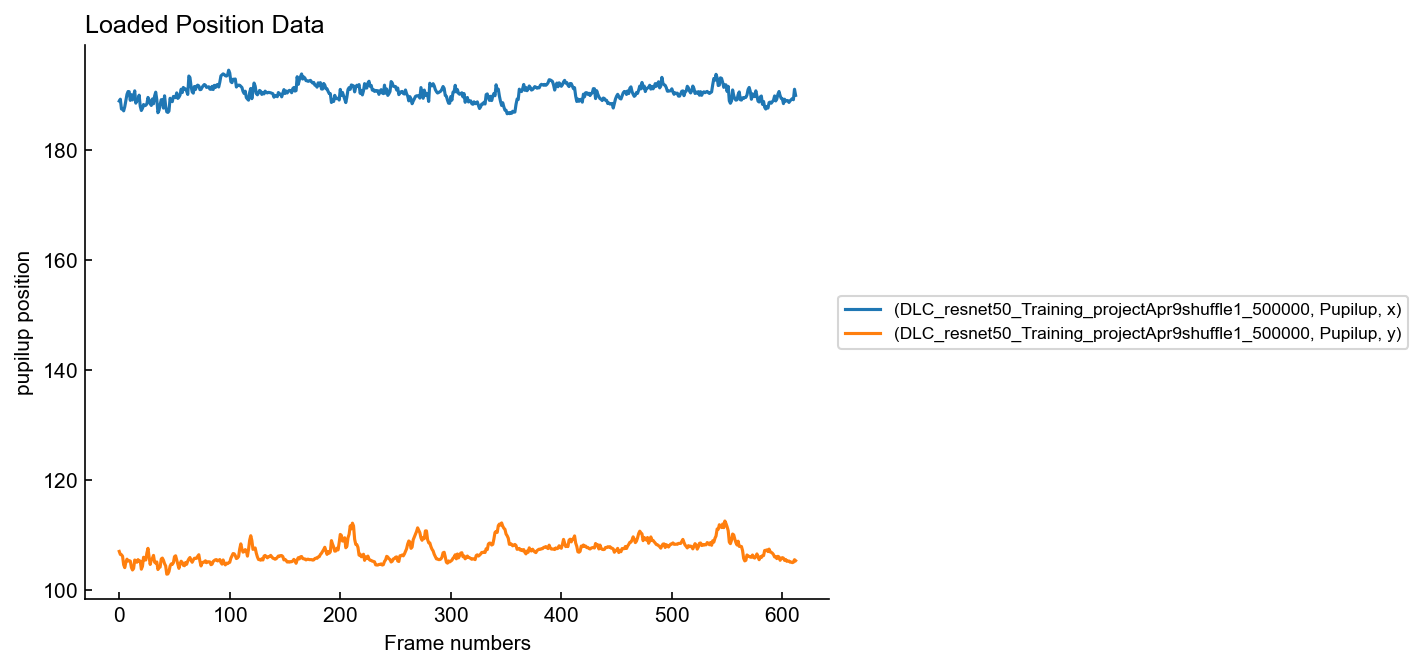

In [34]:
#plot pupil up position
ax1 = df_pupilup.plot(kind="line")
plt.xlabel("Frame numbers")
plt.ylabel("pupilup position")
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Loaded Position Data", loc="left")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

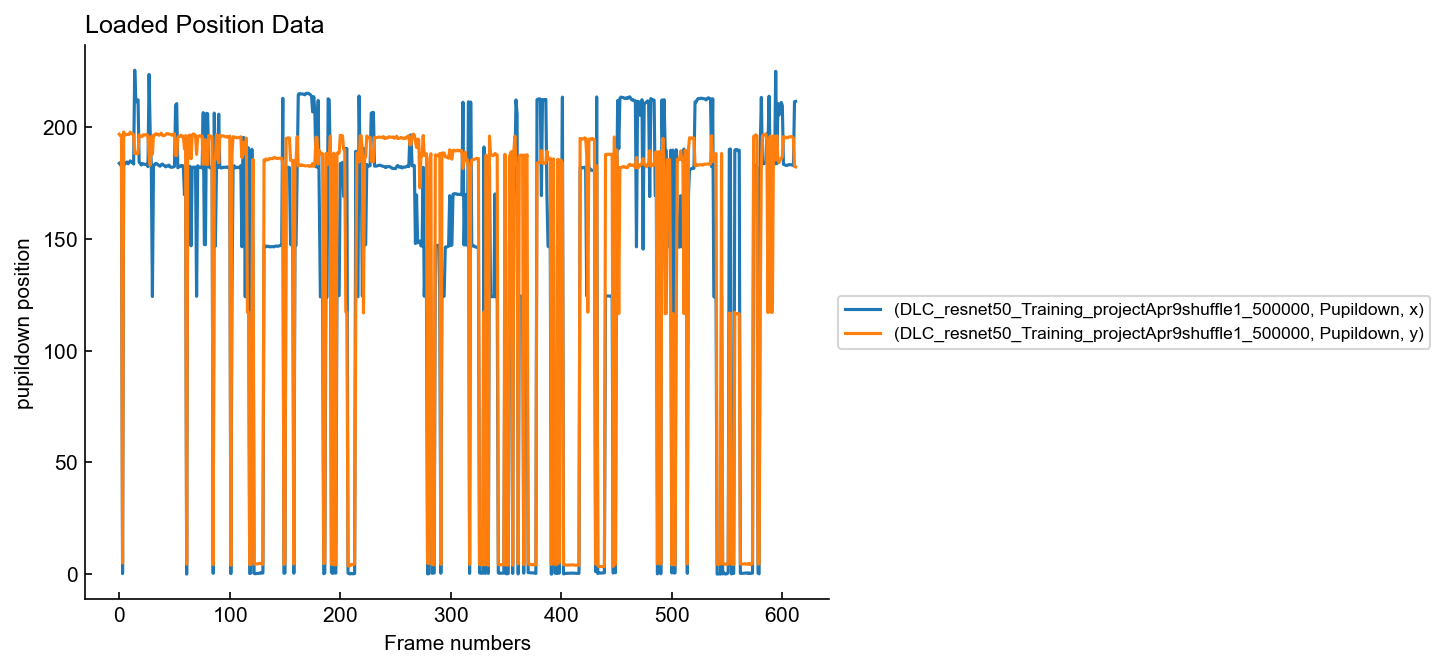

In [35]:
#plot pupil up position
ax1 = df_pupildown.plot(kind="line")
plt.xlabel("Frame numbers")
plt.ylabel("pupildown position")
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Loaded Position Data", loc="left")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()

In [17]:
df, bodyparts, scorer = dlc2kinematics.load_data(dataname)

In [20]:
#compute velocity = pos2-pos1/dt
Pupilup_speed = dlc2kinematics.compute_speed(df,bodyparts=['Pupilup'])

In [22]:
Pupilup_speed

scorer    DLC_resnet50_Training_projectApr9shuffle1_500000           
bodyparts                                          Pupilup           
coords                                               speed likelihood
0                                                 0.120549   0.999997
1                                                 0.120549   0.999996
2                                                 0.305498   0.999998
3                                                 0.219815   0.999998
4                                                 0.066601   0.999997
...                                                    ...        ...
2070                                              0.268942   1.000000
2071                                              1.119249   1.000000
2072                                              0.365855   1.000000
2073                                              0.469255   1.000000
2074                                              0.469255   1.000000

[2075 rows x 2 columns]

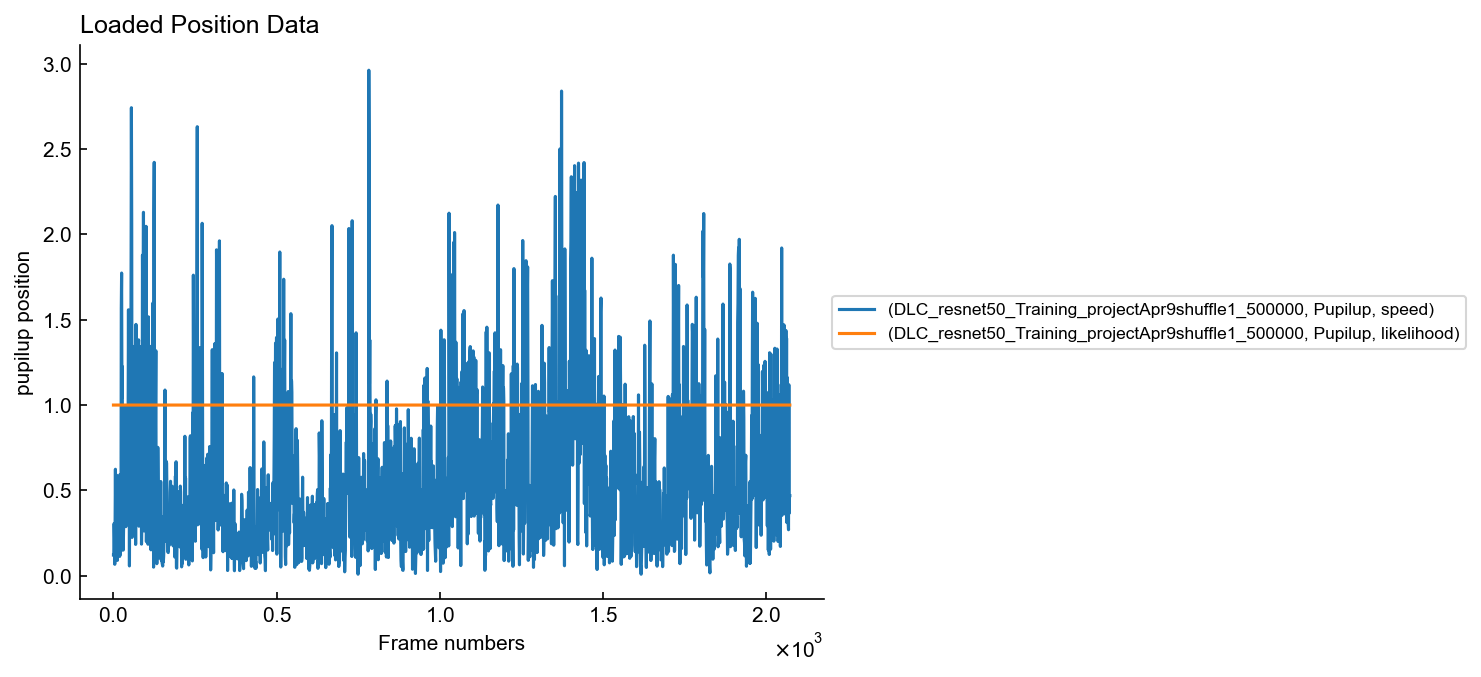

In [23]:
ax1 = Pupilup_speed.plot(kind="line")
plt.xlabel("Frame numbers")
plt.ylabel("pupilup position")
ax1.spines["right"].set_visible(False)
ax1.spines["top"].set_visible(False)
plt.title("Loaded Position Data", loc="left")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.show()